# Analyzing Sexism in Mexican Tweets

**Authors:** Álvaro D. Gómez Antón, Sabah Serhir Serhir, Elisa M. Ramos Monsoriu, Lautaro Paniati Altamirano, Estefania Solís Valverde, Alba Valverde Porcar

<br></br>

<div style="text-align: right"><i>Explaining Online Sexism: Language Models and a Mexican Perspective</i></div>
    
<div style="text-align: right">A Capstone Project by United Nations International Computing Centre (<a href="https://www.unicc.org/">UNICC</a>) and Universitat Politècnica de València (<a href="https://www.upv.es/es">UPV</a>) </div>

---

This notebook aims to provide a comprehensive analysis of sexist content present in Mexican tweets using advanced natural language processing techniques. The primary goal is to detect and classify instances of sexism in the tweets, understand the different types of sexism present, and analyze their prevalence and distribution.

To achieve this, we leverage the power of language models, specifically "Josefina" and "Rosita," which have been trained on a large dataset of Mexican tweets. Josefina is a language model specifically designed for detecting sexist content, while Rosita specializes in identifying different types of sexism within the filtered sexist content. Both models have undergone rigorous development and fine-tuning processes, ensuring their effectiveness in capturing and analyzing sexist language.

The development and training of Josefina and Rosita were carried out in a separate notebook, "2-models-development.ipynb." This notebook provides detailed insights into the methodology used, the preprocessing steps, and the training process for these models. It serves as a valuable reference for understanding the foundations of our analysis in this notebook.

In this notebook, we will explore the results obtained from Josefina's detection of sexist tweets and Rosita's classification of different types of sexism. Additionally, we will utilize other pre-trained models fine-tuned for related tasks, such as cyberbullying detection, racism detection, emotion analysis, sentiment analysis, toxicity detection, contextualized hate speech identification, and irony detection. These models serve as feature extractors to extract additional insights from the filtered sexist content identified by Josefina.

Let's dive into the analysis and gain a deeper understanding of sexism in Mexican tweets!

In [46]:
from typing import List, Dict, Tuple, Iterator, Union, Any, Optional 

## Twitter Data Collection

In this section, we focus on the process of collecting Twitter data related to sexism for our study case in Mexico, with a specific emphasis on evaluating the effectiveness of using targeted keywords to identify and categorize instances of sexism accurately. The idea behind using these keywords is to assess whether they can help collect more instances of sexism, especially in the context of Guadalajara, and determine if they aid in correctly categorizing the instances according to their types.

To ensure a comprehensive dataset that captures a wide range of sexist instances, we employ a strategic approach using specific keywords associated with different types of sexism. These keywords are derived from our collected dataset, which was used to train the models, ensuring that the data collection process aligns with the predefined categories and labels present in the training data.

The objective of incorporating these targeted keywords is to examine whether they truly help in collecting more instances of sexism and, more importantly, to assess their effectiveness in correctly separating and categorizing the instances based on their types. By analyzing the collected data, we can evaluate the degree to which these keywords successfully identify and differentiate instances of sexism according to the predefined categories.

In [71]:
EXTRACTED_DATA_PATH = "../data/extracted"

In [43]:
import time

def prettytime(t: int):
    """
    Converts a given time in seconds to hh:mm:ss format.
    
    Args:
        t (int): Time in seconds.
    
    Returns:
        str: Time in hh:mm:ss format.
    """
    hh, mm = divmod(t, 3600)
    mm, ss = divmod(mm, 60)
    hh, mm, ss = map(lambda x: str(int(x)), [hh, mm, ss])
    return f'{hh.zfill(2)}:{mm.zfill(2)}:{ss.zfill(2)}'

def timeinfo(func):
    """
    Decorator that calculates the execution time of a function.
    
    Args:
        func (function): Function to be decorated.
    
    Returns:
        function: Decorated function.
    """
    def timecalculator(*args, **kwargs):
        t0 = time.time()
        ans = func(*args, **kwargs)
        t1 = time.time() 
        print(f'\nAll work done in {prettytime(t1-t0)} ({round(t1-t0, 3)}s) :)')
        return ans
    return timecalculator

In [44]:
import json

def read_keywords(json_file):
    with open(json_file) as j:
        content = json.load(j)
    return content

def extract_tweets(api, query, geocode):
    """
    Extracts tweets based on a query and geocode.
    
    Args:
        api (tweepy.API): tweepy api to make requests
        query (str): Search query for tweets.
        geocode (str): Geographical coordinates for location-based search.
    
    Returns:
        pd.DataFrame: DataFrame containing extracted tweets.
    """
    buffer, tweets = [None], [None, None]
    while len(tweets) > 1:
        last = buffer.pop()
        if last is None:
            tweets = []
            max_id_ = None
        else:
            max_id_ = last[0]
        tweets = api.search_tweets(
            q=query, 
            geocode=geocode, 
            lang='es', 
            result_type='recent', 
            count=100, 
            max_id=max_id_,
            tweet_mode="extended"
        )
        buffer.extend([tweet.id, tweet.created_at, tweet.full_text] 
                      for tweet in tweets)
        time.sleep(5)
    return pd.DataFrame(data=buffer, columns=['id', 'timestamp', 'tweet'])

def make_query(keywords):
    # Helper function to generate a query from a list of keywords
    raise NotImplemented

@timeinfo
def extract_tweets_given_keywords(api, keywords, geocode, verbose=False):
    """
    Extracts tweets given a set of keywords and geolocation information.
    
    Args:
        api (tweepy.API): tweepy api to make requests
        keywords (dict): Dictionary of keyword types and their corresponding lists of keywords.
        geocode (str): Geographical coordinates for location-based search.
        verbose (bool, optional): Whether to print extraction progress information. Defaults to False.
    
    Returns:
        pd.DataFrame: DataFrame containing the extracted tweets.
    """
    corpus = pd.DataFrame()
    print(f'Extracting tweets from {tuple(map(lambda x: float(x), geocode.split(",")[:2]))}\n') 
    for typ, kwords in keywords.items():
        t0 = time.time()
        query = " OR ".join(kwords)
        #query = make_query(kwords)
        data = extract_tweets(api, query, geocode)
        t1 = time.time()
        data['supposed'] = [typ] * len(data)
        corpus = pd.concat([corpus, data], axis=0, ignore_index=True)
        if verbose: print(f"{len(data)} tweets extracted for '{typ}' keywords in {prettytime(t1-t0)}")
    return corpus


In [55]:
def get_setup_keys(*keys):
    aux, _suggest = {}, False
    for key in keys:
        value = os.getenv(key)
        if value is None:
            value = input(f"Enter your `{key}`: ")
            _suggest = True
        aux[key] = value
    if _suggest:
        print("\nConsider setting keys in system environ to not" \
              "\nenter them each time setting up is required.\n")
    return aux
    
def setup_tweepy_api() -> tweepy.API:
    print("#"*38+"\nAuthenticating with the Twitter API...\n")
    keys = get_setup_keys("TWITTER_CONSUMER_KEY", 
                          "TWITTER_CONSUMER_SECRET", 
                          "TWITTER_ACCESS_TOKEN", 
                          "TWITTER_ACCES_TOKEN_SECRET")
    # Authenticate with the Twitter API.
    auth = tweepy.OAuthHandler(keys["TWITTER_CONSUMER_KEY"], keys["TWITTER_CONSUMER_SECRET"])
    auth.set_access_token(keys["TWITTER_ACCESS_TOKEN"], keys["TWITTER_ACCES_TOKEN_SECRET"])
    print("Authentication succesfully complete.\n"+("#"*38))
    # Create a Twitter object
    return tweepy.API(auth)

api = setupu_tweepy_api()

In [71]:
# read keywords obtained in notebook '3.1-keyword-definition.ipynb'
keywords = read_keywords("../data/extracted/sexism_keywords.json")

# Guadalajara coords (lat,long) plus 100km radius search
location = '20.659698,-103.349609,100km'

# extracting our desired mexican corpus
mexican_corpus = extract_tweets_given_keywords(api, keywords, geocode=location, verbose=True)
mexican_corpus.drop_duplicates(subset="id", inplace=True)

Extracting tweets from (20.659698, -103.349609)

6215 tweets extracted for 'abuse' keywords in 00:06:22
26799 tweets extracted for 'hate' keywords in 00:26:48
11201 tweets extracted for 'profanities' keywords in 00:11:16
18311 tweets extracted for 'violent' keywords in 00:18:45
6134 tweets extracted for 'sexually-explicit' keywords in 00:08:06
4801 tweets extracted for 'possible-sexist' keywords in 00:05:04

All work done in 01:16:23 (4583.427s) :)


## Custom Models Evaluation

In this section, we focus on evaluating the performance of our custom models for detecting and addressing sexism in text. The evaluation process involves two key steps: sample and manual labeling, and the evaluation and comparison of two main models: Josefina and Rosita.

### Sample and manual labeling

To obtain a representative subset of data for evaluation, we employ stratified sampling, a technique suitable for imbalanced data. This approach divides the dataset into homogeneous subgroups based on the "supposed type" of sexism, ensuring proportional representation of each type in the sample.

Unlike simple random sampling, which can lead to biased results in imbalanced datasets, stratified sampling provides a more accurate and representative sample. To determine the minimum sample size, we calculate it based on the desired level of confidence and margin of error.

By utilizing stratified sampling and calculating the appropriate sample size, we ensure a robust evaluation that accurately assesses the performance of our models in detecting different types of sexism.

Next, a team of human annotators (our team) manually labels these instances based on the predefined categories and labels present in the training data.

The manual labeling process plays a crucial role in assessing the performance of our models. It provides a ground truth against which we can compare the model's predictions and determine its accuracy, precision, and recall. By involving human annotators, we incorporate human judgment and domain expertise, enabling us to capture the nuanced aspects of sexism and validate the effectiveness of our models.

In [47]:
def stratified_sample(
    
    data: pd.DataFrame, 
    column: str, 
    confidence: int,
    random_state: Optional[int] = None, 
    shuffle: bool = False
    
) -> pd.DataFrame:
    """
    Returns a stratified sample from a DataFrame, using a specified column as strata and a 
    dictionary of sample sizes for each stratum.
    
    Args:
        data (pd.DataFrame): DataFrame to sample from.
        column (str): Name of the column to use as strata.
        confidence (int): Level of confidence for the sample.
        random_state (int or None, optional): Seed for the random number generator. Default is None.
        shuffle (bool, optional): Whether to shuffle the final sample. Defaults to False.
    
    Returns:
        pd.DataFrame: Stratified sample of the original DataFrame.
    """
    # Initialize the list to store the stratified samples
    sample_list = []
    
    # Calculate the relative frequency of each stratum in the population
    stratum_counts = data[column].value_counts()
    stratum_props = stratum_counts / data.shape[0]
    
    # Calculate the sample size for each stratum using the proportion and the desired overall sample size
    for stratum in stratum_props.index:
        
        stratum_data = data[data[column] == stratum]
        
        # Calculate sample size: n = (z^2 * p * (1-p)) / error^2
        # z-value corresponding to the desired level of confidence
        z = st.norm.ppf(confidence)
        # estimated proportion of the population 
        p = float(stratum_props[stratum])
        # proper stratum size
        stratum_size = round(((z**2)*p*(1-p))/((1-confidence)**2))
        
        # Sample from the current stratum
        stratum_sample = stratum_data.sample(n=stratum_size, random_state=random_state)
        sample_list.append(stratum_sample)
    
    # Concatenate the samples from each stratum into a single DataFrame
    sample = pd.concat(sample_list, axis=0)
    
    # Shuffle the final sample if specified
    if shuffle:
        sample = sample.sample(len(sample))
    
    return sample

In [ ]:
sample = stratified_sample(mexican_corpus, 'supposed', confidence=0.96, random_state=7, shuffle=True)
print(sample['supposed'].value_counts()); sample

In [ ]:
sample.to_csv(F'{EXTRACTED_DATA_PATH}/sample.tsv', sep="\t", index=False)



#### Labeled Data

In [99]:
from datasets import Dataset

sample_labeled = pd.read_csv(f"{EXTRACTED_DATA_PATH}/sample_labeled.tsv", sep="\t") \
                   .rename({"tweet":"text"}, axis=1, inplace=True) \
                   .drop(1925, axis=0, inplace=True) \
                   .dropna(subset=["sexist", "type"])
        
sample_labeled.type = sample_labeled.type.apply(lambda x: x.lower().strip())
sample_labeled.type = sample_labeled.type.apply(
    lambda x: 'profanities' if x in ["profanitites", "profanaties"] else x
)
sample_dataset = Dataset.from_pandas(sample_labeled)
sample_labeled

### Josefina - Evaluation & Comparision

The first model we evaluate is Josefina, our powerful NLP model designed specifically for tackling sexism in text. We assess Josefina's performance on the manually labeled dataset, measuring its accuracy, precision, recall, and F1 scores. By comparing these metrics against the ground truth labels, we can determine how effectively Josefina detects instances of sexism.

In addition to evaluating Josefina's performance on our custom dataset, we also compare its results with other fine-tuned models available for the same task: sexism detection in Spanish. This comparison allows us to understand Josefina's strengths and weaknesses relative to other state-of-the-art models in the Spanish language. By analyzing the similarities and differences in performance, we gain insights into the unique contributions of Josefina and identify areas for improvement and further research.

In [50]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Union, Callable

def predict_from_transformer(
    
        dataset: Dataset, 
        checkpoint_or_path: str,
        mode: str = "label", 
        local_files_only: bool = False,
        tokenizer_kwargs: dict = {}
    
) -> np.array:
    """
    Performs inference using a pre-trained transformer model on a given dataset.

    Args:
        - dataset (Dataset): The dataset to perform inference on. Must contain a "text" column.
        - checkpoint_or_path (str): The checkpoint or path to the pre-trained model.
        - mode (str, optional): The mode for prediction. Possible values are 'label' or 'proba'.
                                'label' returns the predicted label for each sample.
                                'proba' returns the predicted probabilities for each class.
                                 Defaults to 'label'.
        - local_files_only (bool, optional): Whether to only use local files when loading the model.
                                             Defaults to False.
        - tokenizer_kwargs (dict, optional): Additional keyword arguments to be passed to the tokenizer.
                                             Defaults to an empty dictionary.

    Returns:
        numpy.array: An array of predicted labels or probabilities.

    """
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        checkpoint_or_path, local_files_only=local_files_only
    )
    
    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint_or_path, local_files_only=local_files_only
    )
    
    # Create a text classification pipeline
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)
    
    preds = []
    for out in tqdm(pipe(KeyDataset(dataset, "text"), **tokenizer_kwargs)):
        if mode == "label":
            preds.append(out[0]["label"])  # Append the predicted label
        elif mode == "proba":
            out = sorted(out, key=lambda x: x["label"])
            preds.append([class_["score"] for class_ in out])  # Append the predicted probabilities for each class
    
    return np.array(preds)

In [ ]:
opponents = [
    # misogyny
    ## https://huggingface.co/glombardo/misogynistic-statements-classification-model
    ("glombardo/misogynistic-statements-classification-model", "glombardo"),
    
    # sexism
    ## https://huggingface.co/hackathon-pln-es/twitter_sexismo-finetuned-robertuito-exist2021
    ("hackathon-pln-es/twitter_sexismo-finetuned-robertuito-exist2021", "pln-es")
    
    # sexism-base
    ("../src3/detector/purificacion-sexism-detection-v0", "custom-base")
    
    # sexism-full
    ("../src3/detector/purificacion-sexism-detection", "custom-full")
]

y_true, aux = sample.sexist.to_list(), []
for model_name, out_col in opponents:
    preds = predict_from_transformer(sample_dataset, model_name)
    sample_labeled[out_col] = preds
    
    f1_kwargs = {"y_true": y_true, "y_pred": sample[out_col].to_list()}
    for lab, pos_lab in [("positive", 1), ("negative", 0)]:
        aux.append([model, lab, f1_score(**f1_kwargs, pos_label=pos_lab)])
    for avg in ["macro", "micro"]:
        aux.append([model, f"{avg}-avg", f1_score(**f1_kwargs, average=avg)])

josefina_comparison = pd.DataFrame(aux, columns=["model", "label", "f1-score"])

In [ ]:
RED = "#ea544d"
BLUE = "#418fde"
YELL = "#fbd305"
PURP = "#cc64bc"
BLCK = "#3c4444"
GREY = "#f5f5f5"
font = "Calibri"
GREEN="#C4D454"
GREY2='#A08C88'
SALM = '#EB8B59'
BRW='#ECD3BC'
BLUE2='#5BC3E3'

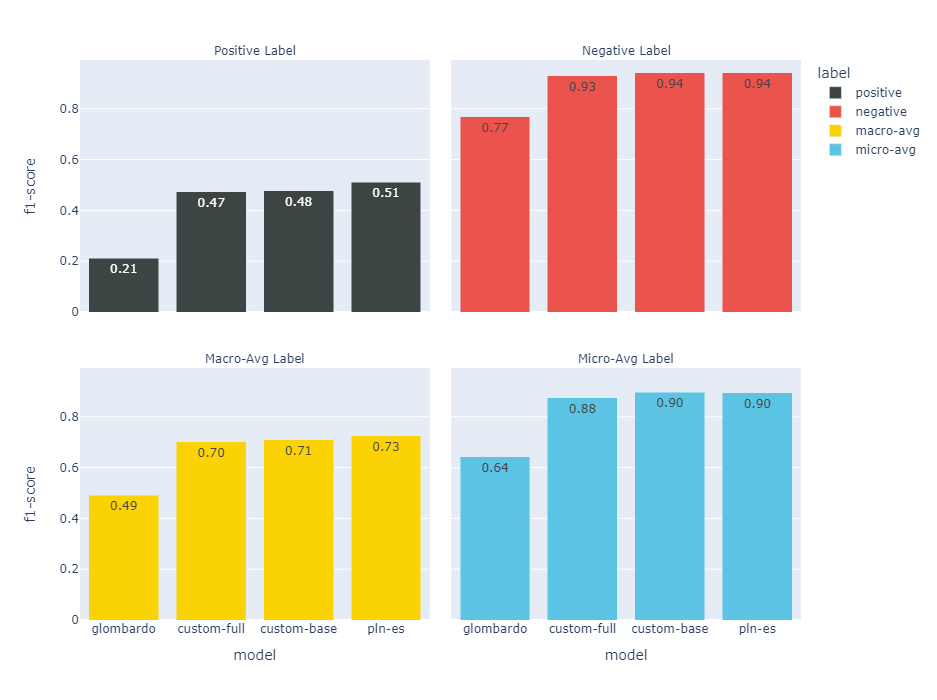

In [15]:
fig = px.bar(
    josefina_comparison.sort_values(by="f1-score"),          
    x='model', y='f1-score', color='label', 
    barmode="stack", 
    text_auto='.2f',
    facet_col='label', 
    facet_col_wrap=2, 
    facet_row_spacing=0.1, 
    facet_col_spacing=0.03,
    color_discrete_sequence=[BLCK, RED, YELL, BLUE2],
    category_orders={"label":["positive", "negative", "macro-avg", "micro-avg"]}
)

fig.for_each_annotation(lambda a: a.update(text=" ".join(reversed(a.text.split("="))).title()))

fig.update_layout(
    autosize=False,
    width=700,
    height=700
)
fig.show()

The custom-base model achieved an F1 score of 0.478 for label_positive and 0.942 for label_negative. The macro-avg F1 score was 0.710, while the micro-avg F1 score was 0.896.

The custom-full model achieved slightly lower F1 scores, with 0.472 for label_positive and 0.929 for label_negative. The macro-avg and micro-avg F1 scores were 0.701 and 0.875, respectively.

The glombardo model showed lower F1 scores overall, with 0.212 for label_positive and 0.770 for label_negative. The macro-avg F1 score was 0.491, while the micro-avg F1 score was 0.643.

Finally, the pln-es model demonstrated higher performance, with an F1 score of 0.511 for label_positive and 0.941 for label_negative. The macro-avg F1 score was 0.726, and the micro-avg F1 score was 0.895.

We observe that while there is a model that performs slightly better than ours, our own model exhibits a commendable level of prediction accuracy. Given the scarcity of models specifically tailored for this task, the comparable F1-scores achieved by our model for both label_positive and label_negative are particularly noteworthy. These results highlight the effectiveness of our model in addressing the challenge of sexism detection. Despite the limited range of model options available for comparison, our model's performance approaches that of the top-performing model. This emphasizes the significance of our work and its potential impact in the absence of a broader selection of models for evaluation.

### Rosita - Evaluation

The second model we evaluate is Rosita, another custom model developed to classify sexism content into proper subtypes. Similar to Josefina, we measure Rosita's performance on the manually labeled dataset, examining its accuracy, precision, recall, and F1 scores (macro averaged). 

In [ ]:
sample_labeled_sexist = sample_labeled.query("sexist == 1")

type_predsv0 = predict_from_transformer(Dataset.from_pandas(sample_labeled_sexist),
                                      "../src3/tagger/rosita-sexism-classification-v0")
type_preds = predict_from_transformer(Dataset.from_pandas(sample_labeled_sexist),
                                      "../src3/tagger/rosita-sexism-classification")
def id2label_sexismtype(id_):
    return {
        0: "abuse",
        1: "hate",
        2: "profanities",
        3: "sexually-explicit",
        4: "violent"
    }[id_]

sample_labeled_sexist["type-base"] = list(map(lambda x: id2label_sexismtype(int(x.split("_")[1])), type_predsv0))
sample_labeled_sexist["type-full"] = list(map(lambda x: id2label_sexismtype(int(x.split("_")[1])), type_preds))

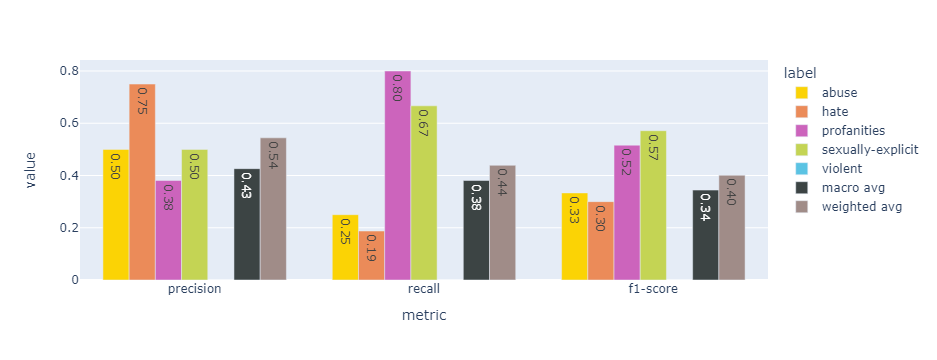

In [429]:
rosita_evaluation1 = pd.DataFrame(classification_report(sample_labeled_sexist.type.to_list(), 
                                                       sample_labeled_sexist["type-base"].to_list(), 
                                                       output_dict=True)) \
                       .drop("accuracy", axis=1).drop("support", axis=0) \
                       .rename_axis("metric", axis=0).rename_axis("label", axis=1) \
                       .melt(ignore_index=False).reset_index()
rosita_evaluation1["model"] = ["type-base"] * len(rosita_evaluation1)

rosita_evaluation2 = pd.DataFrame(classification_report(sample_labeled_sexist.type.to_list(), 
                                                       sample_labeled_sexist["type-full"].to_list(), 
                                                       output_dict=True)) \
                       .drop("accuracy", axis=1).drop("support", axis=0) \
                       .rename_axis("metric", axis=0).rename_axis("label", axis=1) \
                       .melt(ignore_index=False).reset_index()
rosita_evaluation2["model"] = ["type-full"] * len(rosita_evaluation1)

rosita_evaluation = pd.concat([rosita_evaluation1, rosita_evaluation2], axis=0)

px.bar(rosita_evaluation, 
       x="model", 
       y="value", 
       color="label", 
       barmode="group", 
       text_auto='.2f',
       facet_row="metric",
       facet_row_wrap=1,
       color_discrete_map={
          "violent": BLUE2,
          "hate": SALM,
          "abuse": YELL,
          "sexually-explicit": GREEN,
          "profanities": PURP,
          "macro avg": BLCK, 
          "weighted avg": GREY2
       })

The model's performance report reveals varying precision, recall, and F1-scores across different labels. Notably, the secually-explicit and profanities labels demonstrated a higher precision and recall, resulting in a relatively higher F1-score. Also, hate label shows the highest precision. The macro and micro averages further emphasize the need for fine-tuning and optimization to enhance the model's overall performance.

## Large Language Model Feature Extraction

In this section, we delve into the realm of large language models and their role in feature extraction for our sexism detection task. We leverage the power of models like Josefina and Rosita, along eith other fine tuned mdoels, to gain deeper insights and explore their capabilities in identifying and analyzing sexist language in our Mexican data.

In [257]:
mexican_corpus = pd.read_csv("../data/extracted/mexican_corpus_v11.tsv", sep="\t")
mexican_corpus

,id,timestamp,tweet,supposed
0,1655693993186050048,2023-05-08 21:59:43+00:00,@___Ninna Jajajaja la neta no me quiero ir com...,abuse
1,1655693973594288128,2023-05-08 21:59:39+00:00,Quieren otra coincidencia como cosa del diablo...,abuse
2,1655693916140630026,2023-05-08 21:59:25+00:00,"@Hans2412 No, el pueblo no es tonto…NO nos chu...",abuse
3,1655693660422303744,2023-05-08 21:58:24+00:00,Que te vean como su mayor ejemplo es la cosa m...,abuse
4,1655692938284761095,2023-05-08 21:55:32+00:00,"@CarneDeAzucar Jajaja. Pues si, pero ni una co...",abuse
...,...,...,...,...
60429,1652282516865273856,2023-04-29 12:03:44+00:00,@Daniarac @twittgr2099 Por qué hay incongruenc...,possible-sexist
60430,1652272934629588993,2023-04-29 11:25:40+00:00,@MegaNews_MX La mujer comenzó a grabar para de...,possible-sexist
60431,1652266477590925313,2023-04-29 11:00:00+00:00,Uno de los géneros que más marcaron la vida de...,possible-sexist
60432,1652264825752256513,2023-04-29 10:53:26+00:00,"Una mujer acuchilló a su pareja, causándole he...",possible-sexist


In [ ]:
def clean(
    
        text: str, 
        keep_case: bool = False,
        keep_accents: bool = False,
        keep_numbers: bool = False,
        lmhe_tokens: Optional[Dict[str, str]] = None, 
        constraints: Optional[List[Tuple[str, str]]] = None,
        allowed_punctuation: Optional[str] = None
    
    ) -> str:
    """
    Clean a given text
    
    Args:
        - text: string to clean
        - keep_case: wether to keep original case (True) or not (False). If not text will be lowercased. Default to False.
        - keep_accents: wether to keep accents (True) or not (False). Default to False.
        - keep_numbers: wether to keep numbers (True) or not (False). Default to False.
        - lmhe_tokens (optional): which stands for link-mention-hashtag-emoji_tokens. A dict containing how to represent.
          those items in the final text. If nothing provided (neither dict or specific key), they will be removed.
        - constraints (optional) : any special substitution you may want to apply to the text. It must be a list of tuples 
          containing the corresponding regex to capture (first element of the tuple) and the string to substitue 
          it (second element).
        - allowed_punctuation: string containing custom punctuation you may want to avoid cleaning.
        
    Returns
        str: cleaned text
    """
    
    # lowercase
    if not keep_case:
        text = text.lower() 
    
    #remove \n and \r
    text = text.replace('\r', '').replace('\n', ' ')
    
    if lmhe_tokens is not None:
        # handle links
        text = re.sub(r'(?:www\.|https?://)\S+', lmhe_tokens.get("link", ''), text, flags=re.MULTILINE)  
        
        # handle mentions
        text = re.sub(r'\@\S+', lmhe_tokens.get("mention", ''), text) 
        
        # handle hashtags
        text = re.sub(r'#\S+', lmhe_tokens.get("hashtag", ''), text)
        
        # handle emojis
        text = emoji.replace_emoji(text, lmhe_tokens.get("emoji", ''))  
        
    else:
        # remove links, mentions, hashtags and emojis
        text = re.sub(r'(?:#|\@|www\.|https?://)\S+', '', text, flags=re.MULTILINE) 
        text = emoji.replace_emoji(text, '')
     
    # specific constraints
    if constraints is not None:
        for regex, token in constraints:
            text = re.sub(regex, token, text, flags=re.I)
    
    # remove accents
    if not keep_accents:
        text = unidecode.unidecode(text)  
    
    ## all symbols and punctuation
    banned_list = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'+'—'  
    ## allowed punctuation
    if allowed_punctuation is not None:  
        banned_list = re.sub(r"[%s]" % re.escape(allowed_punctuation), "", banned_list)
    # remove symbols and punctuation
    text = text.translate(str.maketrans('', '', banned_list)) 
    
    # remove numbers
    if not keep_numbers:
        text = re.sub(r'\d+', '', text)  
    
    # remove extra and leading blanks
    text = re.sub("\s\s+" , " ", text).strip()  
    
    return text

In [259]:
mexican_clean = mexican_corpus.copy()
mexican_clean.rename({"tweet":"text"}, axis=1, inplace=True)
mexican_clean.text = mexican_clean.text.apply(clean, 
                                            keep_case=False,
                                            keep_accents=True,
                                            keep_numbers=True,
                                            allowed_punctuation="'\"!¿?.,")
# Pasar a la zona horaria de México
## Obtén la zona horaria de México
import pytz
mexico_timezone = pytz.timezone('America/Mexico_City')
## Convierte la columna 'timestamp' a tipo datetime
mexican_clean['timestamp'] = pd.to_datetime(mexican_clean['timestamp'])
## Aplica la conversión de zona horaria a la columna 'timestamp'
mexican_clean['timestamp'] = mexican_clean['timestamp'].dt.tz_convert(mexico_timezone)

In [303]:
import pandas as pd
import datasets
from transformers import TextClassificationPipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Union, Callable

@timeinfo
def llm_feature_extraction(
    df: pd.DataFrame, 
    models: List[Dict[str, Union[str, Callable]]], 
    verbose: bool = False,
    return_Dataset: bool = False
) -> pd.DataFrame:
    """
    Extracts features using language models specified in the 'models' parameter.

    Args:
        df (pd.DataFrame): Input DataFrame containing the text data.
        models (List[Dict[str, Union[str, Callable]]]): List of model settings
            including the model name, output column name, and optional cleaning function.
        verbose (bool, optional): Whether to print extraction progress. Defaults to False.
        return_Dataset (bool, optional): Whether to return the Dataset object instead
            of converting it to a pandas DataFrame. Defaults to False.
    
    Returns:
        pd.DataFrame or datasets.Dataset: Extracted features as a DataFrame if 'return_Dataset' is False,
            otherwise, the Dataset object containing the extracted features.
    """
    # Convert input DataFrame to Hugging Face Dataset
    dataset = datasets.Dataset.from_pandas(df)
    
    # Remove redundant index column if present
    if "__index_level_0__" in dataset.column_names:
        dataset.remove_columns("__index_level_0__")
    
    # Iterate over each model to extract features
    for model_settings in models:
        if verbose:
            print(f"Extracting \'{model_settings['out_col']}\' feature...")
        
        out_col = model_settings['out_col']
        
        try:
            # Perform predictions using the specified language model
            preds = predict_from_transformer(dataset, model_settings["model_name"])
        except Exception as ex:
            print(f"Oops, encountered an error: {ex}")
            if return_Dataset:
                return dataset
            return dataset.to_pandas(), dataset
        
        # Add the extracted feature column to the Dataset
        dataset = dataset.add_column(model_settings['out_col'], preds)
        
        # Apply optional cleaning function to the extracted feature column
        clean_func = model_settings.get("clean_label", None)
        if clean_func:
            def clean_label(example):
                example[out_col] = clean_func(example[out_col])
                return example
            dataset = dataset.map(clean_label)
    
    # Return the Dataset object if specified
    if return_Dataset:
        return dataset
    # Otherwise, convert the Dataset to a pandas DataFrame and return
    return dataset.to_pandas()

### Josefina in action

In this section, we utilize Josefina, our NLP model specifically designed to detect sexism in text, to analyze the Mexican dataset. Josefina's main task is to identify and flag tweets containing sexist content. 

Using Josefina, we filter out the tweets deemed sexist, allowing us to focus on this specific subset of data. This enables us to conduct further feature extraction, uncovering sexism types, sentiment, and other nuances associated with sexism..

In [ ]:
model = [
    {
        "model_name": "../src3/detector/purificacion-sexism-detection", 
        "out_col": "sexist", 
        "clean_label": lambda x: int(x == "LABEL_1")
    } 
]
mexican_corpus_labeled = llm_feature_extraction(mexican_clean, models=model)

In [268]:
mexican_corpus_labeled.to_csv("../data/extracted/mexican_corpus_labeled.tsv", sep="\t")

In [28]:
import pytz
mexican_corpus_labeled = pd.read_csv('../data/extracted/mexican_corpus_labeled.tsv', delimiter='\t', index_col=0)
mexico_timezone = pytz.timezone('America/Mexico_City')

# Convierte la columna 'timestamp' a tipo datetime
mexican_corpus_labeled['timestamp'] = pd.to_datetime(mexican_corpus_labeled['timestamp'])
# Aplica la conversión de zona horaria a la columna 'timestamp'
mexican_corpus_labeled['timestamp'] = mexican_corpus_labeled['timestamp'].dt.tz_convert(mexico_timezone)

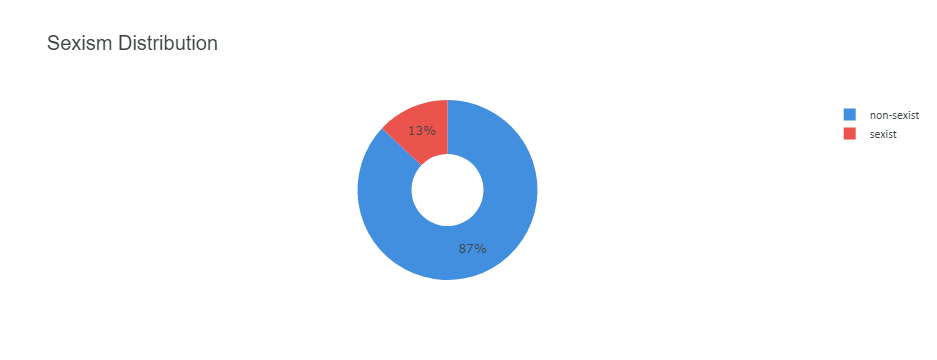

In [24]:
import plotly.graph_objects as go

def create_donut_chart(data,
                       colors, labels=None, label_font='Arial', 
                       legend_font='Arial', legend_color='black', 
                       title_size=20, title_font='Arial', title_color='black',
                       background_color='white'):
    values = data.value_counts(normalize=True) * 100
    if not labels:
        labels = values.index.tolist()
    fig = go.Figure(data=go.Pie(labels=labels, values=values, hole=0.4, textposition='inside'))
    
    fig.update_traces(marker=dict(colors=colors))
    fig.update_layout(
        title='Sexism Distribution',
        title_font=dict(size=title_size, family=title_font, color=title_color),
        plot_bgcolor=background_color,
        legend=dict(
            font=dict(family=legend_font, color=legend_color),
        )
    )
    return fig
    

colors = [BLUE, RED]  
fig1 = create_donut_chart(mexican_corpus_labeled.sexist, labels=['non-sexist', 'sexist'], colors=colors, 
                   legend_font=font, legend_color=BLCK, label_font=font, title_color=BLCK)
fig1.show()

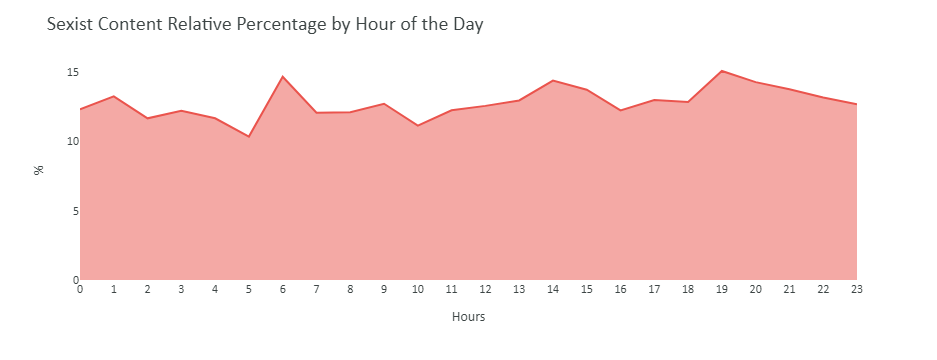

In [32]:
from datetime import timedelta

def temporal_chart_perc(data, 
                        line_color, 
                        title_size, title_font, title_color,
                        axes_size, axes_font, axes_color, 
                        text_size, text_font,
                        background_color, panel_color):    
    
    tweets_per_hour = data.groupby(data['timestamp'].dt.hour) \
                          .size().reset_index(name='total_tweets')
    
    total_sexist_tweets_per_hour = data.query("sexist==1") \
                                       .groupby(data['timestamp'].dt.hour) \
                                       .size().reset_index(name='total_tweets')

    #total_tweets = tweets_per_hour['total_tweets'].sum()
    tweets_per_hour['percentage'] = (total_sexist_tweets_per_hour["total_tweets"] / tweets_per_hour['total_tweets']) * 100


    fig = px.area(tweets_per_hour, x='timestamp', y='percentage')
    fig.update_layout(
        xaxis=dict(
            title="Hours",
            title_font=dict(size=axes_size, family=axes_font, color=axes_color),
            tickfont=dict(size=text_size, family=text_font, color=axes_color),
        ),
        yaxis=dict(
            title='%',
            title_font=dict(size=axes_size, family=axes_font, color=axes_color),
            tickfont=dict(size=text_size, family=text_font, color=axes_color),
        )
    )

    # Personalize the graph
    fig.update_traces(line_color=line_color)
    fig.update_xaxes(
        type='category',
        title_font=dict(size=axes_size, family=axes_font, color=axes_color),
        tickfont=dict(size=text_size, family=text_font, color=axes_color),
    )
    fig.update_layout(
        title='Sexist Content Relative Percentage by Hour of the Day',
        title_font=dict(size=title_size, family=title_font, color=title_color),
        legend=dict(font=dict(size=text_size, family=text_font, color=title_color)),
        plot_bgcolor=background_color,
        paper_bgcolor=panel_color
    )
    #plt.rcParams['axes.facecolor'] = panel_color
    #fig.update_layout(
    #    autosize=False,
    #    width=600,
    #    height=300,)
    fig.show()

temporal_chart_perc(mexican_corpus_labeled, line_color=RED, title_size=20, title_font=font,
                      title_color=BLCK, axes_size=14, axes_font=font, axes_color=BLCK,
                      text_size=12, text_font=font, background_color='#FFFFFF', panel_color='white')

### Rosita classifications

In addition to Josefina's contributions, we employ Rosita, our other model trained to classify different types of sexism in text. Building upon the filtered sexist content identified by Josefina, Rosita takes on the task of categorizing these instances into specific types of sexism.

Using advanced classification techniques, Rosita analyzes the linguistic features and context of the filtered content to determine the underlying sexist categories present. By identifying and labeling the types of sexism, such as "hate", "violence", or "sexually-explicit", among others, we gain valuable insights into the nature and prevalence of these specific forms of sexism within the Mexican dataset.


By combining the power of Josefina and Rosita, we are able to not only detect and filter out sexist content but also gain a comprehensive understanding of the specific types of sexism prevalent in the Mexican dataset. This information is instrumental in shaping interventions, policies, and initiatives to combat sexism and foster a more inclusive online environment.

In [ ]:
model = [
    {
        "model_name": "../src3/tagger/rosita-sexism-classification-v0", 
        "out_col": "sexism_type", 
        "clean_label": lambda x: id2label_sexismtype(int(x.split("_")[1]))
    } 
]
mexican_sexist_featured = mexican_corpus_labeled.query("sexist==1")
mexican_sexist_featured = llm_feature_extraction(mexican_sexist_featured, models=model)

In [51]:
mexican_sexist_featured = pd.read_csv('../notebooks2/mexican_sexist_featured_final_final.tsv', delimiter='\t') 
# Convierte la columna 'timestamp' a tipo datetime
mexican_sexist_featured['timestamp'] = pd.to_datetime(mexican_sexist_featured['timestamp'])
# Aplica la conversión de zona horaria a la columna 'timestamp'
mexican_sexist_featured['timestamp'] = mexican_sexist_featured['timestamp'].dt.tz_convert(mexico_timezone)

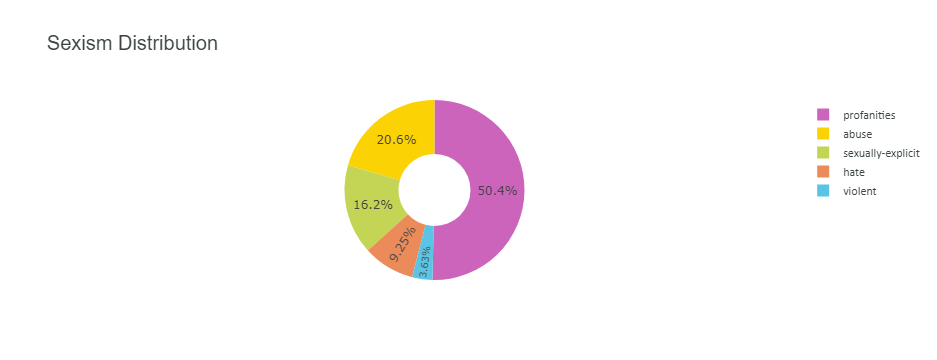

In [52]:
colors = [PURP, YELL, GREEN, SALM, BLUE2] 
fig2 = create_donut_chart(mexican_sexist_featured.query("sexism_type!='non-sexist'").sexism_type, colors=colors, 
                   legend_font=font, legend_color=BLCK, label_font=font, title_color=BLCK)
fig2.show()

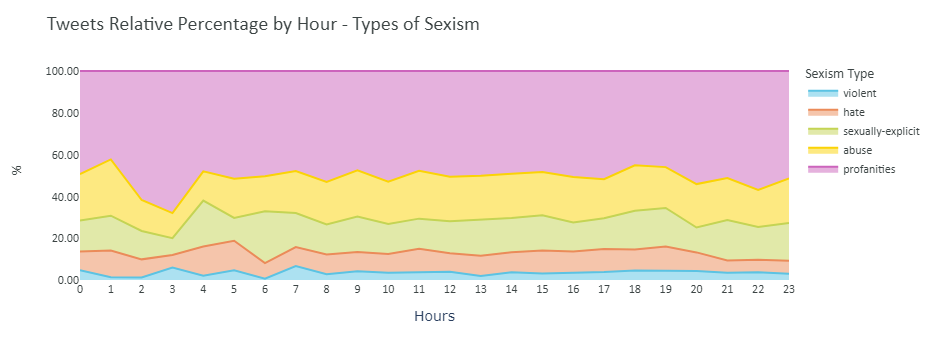

In [53]:
def temporal_chart_type(data, title_size, title_font, title_color,
                        axes_size, axes_font, text_size, text_font,
                        background_color, axes_color, panel_color):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    total_tweets_per_hour = data.groupby(data['timestamp'].dt.hour).size().reset_index(name='total')
    tweets_per_hour = data.groupby([data['timestamp'].dt.hour, 'sexism_type']).size().reset_index(name='frequency')
    tweets_per_hour = tweets_per_hour.merge(total_tweets_per_hour, on='timestamp')
    tweets_per_hour['percentage'] = tweets_per_hour['frequency'] / tweets_per_hour['total'] * 100
    #tweets_per_hour.sort_values(by='percentage', inplace=True)
    colores = [ "#c4d454", "#a08c88", "#fbd305", "#EEC3B9", "#418fde"]

    fig = px.area(tweets_per_hour, x='timestamp', y="percentage", color='sexism_type',
                  category_orders={"sexism_type": tweets_per_hour.groupby("sexism_type")["percentage"].sum().sort_values().index.tolist()},
                 color_discrete_map={
                      "violent": BLUE2,
                      "hate": SALM,
                      "abuse": YELL,
                      "sexually-explicit": GREEN,
                      "profanities": PURP
                      # Agrega más colores y tipos de sexismo según sea necesario
                  })
    
    fig.update_xaxes(
        type='category',
        title_font=dict(size=axes_size, family=axes_font, color=axes_color),
        tickfont=dict(size=text_size, family=text_font, color=axes_color),
    )
    fig.update_yaxes(
        title='%',
        title_font=dict(size=axes_size, family=axes_font, color=axes_color),
        tickfont=dict(size=text_size, family=text_font, color=axes_color),
        tickformat=".2f"
    )

    # Personalize the graph
    fig.update_layout(
        title='Tweets Relative Percentage by Hour - Types of Sexism',
        title_font=dict(size=title_size, family=title_font, color=title_color),
        legend=dict(font=dict(size=text_size, family=text_font, color=title_color),
                    title="Sexism Type"),
        plot_bgcolor=background_color,
        paper_bgcolor=panel_color,
        xaxis=dict(title='Hours'),

    )
    #fig.update_layout(
    #    autosize=False,
    #    width=600,
    #    height=300,)
    fig.show()

temporal_chart_type(mexican_sexist_featured, title_size=20, title_font=font, title_color=BLCK,
                    axes_size=14, axes_font=font, axes_color=BLCK,
                    text_size=12, text_font=font, background_color='white', panel_color="white")


### Other models from the hub

Finally, we explore the performance of several fine-tuned models on the filtered sexist content from the Josefina model. These models, originally trained for different tasks, provide additional insights into the nature of the sexist tweets. Let's take a closer look at each model and its focus:

- Cyberbullying Detection: The "roberta-base-bne-finetuned-cyberbullying-spanish" model specializes in identifying instances of cyberbullying in Spanish text.

- Racism Detection: The "datathon-against-racism" model focuses on detecting racism in text.

- Emotion Classification: The "twitter-xlm-roberta-emotion-es" model is designed to identify emotions expressed in Spanish text.

- Sentiment Analysis: The "roberta_bne_sentiment_analysis_es" model enables us to determine the sentiment of the tweets, classifying them as either "positive" or "negative."

- Toxicity Detection: The "distilbert-base-multilingual-cased-toxicity" model helps us identify any toxic content within the filtered sexist tweets.

- Contextualized Hate Speech Detection: The "beto-contextualized-hate-speech" model focuses on detecting hate speech in context.

- Hate Speech Detection: The "robertuito-hate-speech" model is specifically trained to identify hate speech instances in text.

- Irony Detection: The "robertuito-irony" model is trained to recognize instances of irony in text.

The integration of these diverse fine-tuned models as feature extractors unlocks a powerful analytical approach to comprehensively understand the various facets of sexist content within the Mexican dataset. By leveraging models trained on tasks such as cyberbullying, racism, emotion, sentiment, toxicity, hate speech, and irony, we gain valuable insights into the different dimensions of the detected sexist tweets. This multifaceted analysis enables us to explore the underlying patterns in the data, providing a comprehensive view of the prevalent forms of sexism on social media. By harnessing the power of these models as feature extractors, we can develop effective strategies to address and combat sexism, ultimately fostering a safer and more inclusive online environment.

In [ ]:
models = [   
    # cyberbulling
    ## https://huggingface.co/JonatanGk/roberta-base-bne-finetuned-cyberbullying-spanish?text=Eres+muy+feo%21
    {
        "model_name": "JonatanGk/roberta-base-bne-finetuned-cyberbullying-spanish", 
        "out_col": "cyberbulling", 
        "clean_label": lambda x: "-".join(x.lower().split("_"))
    },

    # racism
    ## https://huggingface.co/jaumefib/datathon-against-racism?text=Ya+est%C3%A1n+detenidos+dos+rumanos+se%C3%B1alados+de+cometer+fraudes+bancarios.
    {
        "model_name": "jaumefib/datathon-against-racism", 
        "out_col": "racist", 
        "clean_label": lambda x: "racist" if int(x.split("_")[1]) else "non-racist"
    },

    # emotion
    ## https://huggingface.co/daveni/twitter-xlm-roberta-emotion-es
    {
        "model_name": "daveni/twitter-xlm-roberta-emotion-es", 
        "out_col": "emotion", 
    },  
    
    # positive-negative
    ## https://huggingface.co/edumunozsala/roberta_bne_sentiment_analysis_es?text=Se+trata+de+una+pel%C3%ADcula+interesante%2C+con+un+solido+argumento+y+un+gran+interpretaci%C3%B3n+de+su+actor+principal
    {
        "model_name": "edumunozsala/roberta_bne_sentiment_analysis_es", 
        "out_col": "sentiment", 
        "clean_label": lambda x: "positive" if x == "Positivo" else "negative"
    }, 
    
    # toxicity
    ## https://huggingface.co/citizenlab/distilbert-base-multilingual-cased-toxicity
    {
        "model_name": "citizenlab/distilbert-base-multilingual-cased-toxicity", 
        "out_col": "toxic", 
        "clean_label": lambda x: "-".join(x.split("_"))
    },   
    
    # contextualized hate speech
    ## https://huggingface.co/piuba-bigdata/beto-contextualized-hate-speech/blob/main/README.md
    {
        "model_name": "piuba-bigdata/beto-contextualized-hate-speech", 
        "out_col": "hate", 
        "clean_label": lambda x: x.lower()
    }, 

    # hate2
    ## https://huggingface.co/pysentimiento/robertuito-hate-speech
    {
        "model_name": "pysentimiento/robertuito-hate-speech", 
        "out_col": "hate2"
    },

    # irony
    ## https://huggingface.co/pysentimiento/robertuito-irony
    {
        "model_name": "pysentimiento/robertuito-irony", 
        "out_col": "irony", 
        "clean_label": lambda x: "-".join(x.lower().split(" "))
    }
]


mexican_sexist_featured = llm_feature_extraction(mexican_sexist_featured, models, verbose=True)

In [ ]:
mexican_sexist_featured

In [ ]:
mexican_sexist_featured.to_csv(f"{EXTRACTED_DATA_PATH}/mexican_corpus_featured.tsv", sep="\t", index=False)

#### Results

The results of the analysis are visualized through an interactive plot. The interactBarras function has been designed to create a dropdown menu that allows users to select different variables, representing different aspects of sexism, such as cyberbullying, racism, emotion, sentiment, toxicity, hate speech, hateful content, and irony. The plot displays the distribution of each variable across different sexism types. Each bar in the plot represents the percentage of tweets classified under a specific sexism type for a given variable.

The plot is interactive, enabling users to explore the distribution of each variable by selecting it from the dropdown menu. As a user selects a variable, the plot dynamically updates to display the distribution of that variable across different sexism types. The plot is color-coded to distinguish between different values of the selected variable, providing a clear visual representation of the distribution.

This interactivity facilitates a comprehensive understanding of the various dimensions of sexism within the Mexican dataset. Users can analyze the prevalence and distribution of different types of sexist content, gaining insights into the specific characteristics and patterns associated with each sexism type. Such visual analysis helps in identifying areas that require further attention and intervention, guiding the development of targeted strategies to address and combat sexism effectively.

In [54]:
import plotly.express as px
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
def interactBarras(data, font_family=font, font_size=12, include_average=False):
    # Obtener la lista de variables
    variables = ["cyberbulling", "racist", "emotion", "sentiment", "toxic", "hate", "hate2", "irony"]
    names = ["Cyber-bullying", "Racism", "Emotions", "Sentiment", "Toxicity", "Hate Speech", "Hateful", "Irony"]

    # Crear el desplegable
    dropdown = widgets.Dropdown(options=variables, description='Variable:')

    # Crear el contenedor para el gráfico
    graph_container = widgets.Output()

    # Función para actualizar el gráfico cuando se seleccione una nueva variable
    def update_plot(variable):
        df_counts = data.groupby('sexism_type')[variable].value_counts(normalize=True).mul(100).reset_index(name='percentage')
        if include_average:
            mean_df_counts = final_data.groupby('sexist')[variable].value_counts(normalize=True).mul(100).reset_index(name='percentage')
            mean_df_counts.sexist = mean_df_counts.sexist.apply(lambda x: "average")
            df_counts = pd.concat([mean_df_counts.rename(columns={"sexist":"sexism_type"}), df_counts], axis=0)
        colores =  [BLUE, RED, YELL, GREEN, SALM, BLUE2, BRW, BLCK, PURP]
        fig = px.bar(df_counts, y="sexism_type", x="percentage", 
                     color=variable,  color_discrete_sequence=colores)
        fig.update_layout(
            title=f'Distribution of {names[variables.index(variable)]} by Sexism Type',
            title_font=dict(size=20, family=font_family, color='black'),
            xaxis=dict(title="%"),
            yaxis=dict(title=None),
            legend=dict(title=None),
            font=dict(family=font_family, size=font_size),

            plot_bgcolor='white'
        )

        with graph_container:
            graph_container.clear_output(wait=True)
            fig.show()

    # Mostrar el desplegable y el gráfico inicial
    display(dropdown)
    display(graph_container)
    update_plot(dropdown.value)

    # Actualizar el gráfico cuando se seleccione una nueva variable
    def dropdown_eventhandler(change):
        update_plot(change.new)

    dropdown.observe(dropdown_eventhandler, names='value')
interactBarras(mexican_sexist_featured)

Dropdown(description='Variable:', options=('cyberbulling', 'racist', 'emotion', 'sentiment', 'toxic', 'hate', …

Output()

Here we have some key findings:

**Hate Speech**

- The analysis of other models revealed that hate speech towards women is the predominant type of sexist content observed in the dataset. This finding aligns with the overall objective of identifying and addressing sexism on social media platforms.

- Racism, while not as prevalent as hate speech towards women, displayed its peak in the "profanities" type of content. This suggests that racist remarks tend to be more explicit and offensive in nature.

- The analysis also revealed that the category labeled as "violent" contains a higher proportion of hate speech towards the LGBT community compared to other categories. This finding highlights the specific targeting of this marginalized group within the context of sexist content.

- Content related to appearance was found to be predominantly associated with sexually-explicit material. This indicates that discussions or comments about physical appearance often tend to have a sexual connotation.

**Emotions**

- Among the emotions detected in the sexist tweets, anger was the most frequently observed, reaching its maximum expression in the "profanities" type of content. This suggests that sexist remarks are often fueled by anger and hostility.

- Interestingly, sexually-explicit tweets were also classified as containing joy more often than other types of content. This finding might indicate the presence of a certain level of humor or pleasure associated with such content, albeit in a sexist context.

- The emotion of sadness appeared more prominently in the category labeled as "abuse," suggesting that this type of content elicits feelings of distress and sorrow.

**Cyberbullying**

- Furthermore, the analysis revealed that the categories "violent," "sexually-explicit," and "profanities" showed a higher likelihood of containing cyberbullying-related content compared to the categories of "hate" and "abuse." This finding emphasizes the interconnectedness between sexist content and online harassment.

**Irony**

- Additionally, the categories labeled as "abuse" and "sexually-explicit" were found to have the highest incidence of ironic content. This indicates that within these types of sexist content, ironic statements or expressions are frequently employed, adding a nuanced layer of meaning to the conveyed messages. The utilization of irony in these contexts may serve as a way to mask or downplay the severity of the abusive or sexually explicit language used, further emphasizing the need for comprehensive understanding and analysis of the content.

These key findings shed light on the specific characteristics and patterns within different types of sexist content and provide valuable insights for understanding the nature and impact of sexism on social media platforms.